In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import random
from pytorch_lightning.loggers import TensorBoardLogger

import os
import torch
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as T
import warnings
import pickle
warnings.filterwarnings("ignore")

from src.data_assemble.wrap_data import *
from src.models.WindCNN import *
from src.data_assemble.wrap_data import *

# %load_ext tensorboard
# %tensorboard --logdir lightning_logs/
random.seed(24)

In [2]:

path_to_data = os.path.join('data', 'nn_data')
st_split_dict = train_val_test_split(path_to_data, train = 0.5, val = 0.25, test = 0.25, verbose = True)

{'Train': ['Туапсе', 'Краснодар, Круглик'], 'Val': ['Анапа'], 'Test': ['Приморско-Ахтарск']}


In [3]:
st_split_dict

{'Train': ['Туапсе', 'Краснодар, Круглик'],
 'Val': ['Анапа'],
 'Test': ['Приморско-Ахтарск']}

In [4]:
path_to_dump = os.path.join('data','nn_data')
X, y = extract_splitted_data(path_to_dump, st_split_dict)

In [5]:
batch_size = 1024
args = {
    "in_channels": X["Train"].shape[1],
    "out_channels_1": 64,
    "k_size_1": 3,
    "stride_1": 1,
    "dilation_1": 1,
    # "padding_1": 'same',

    "out_channels_2": 32,
    "k_size_2": 3,
    "stride_2": 1,
    "dilation_2": 1,
    # "padding_2": 'same',

    "maxpool_2": 2,
    "fc_size": 800,

    "pos_weight": torch.tensor(1. / (y["Train"].mean() + 1e-8)),
    "threshold": 0.99,

    "lr": 1e-3,
    "b1": 0.9,
    "b2": 0.999,
}

In [6]:
logger = TensorBoardLogger(save_dir='logs/wind', name='windnet')
trainer = pl.Trainer(max_epochs=50,
                    gpus='1',
                    benchmark=True,
                    check_val_every_n_epoch=1,
)


dm = WindDataModule(X=X, y=y, batch_size=batch_size, downsample=False)
model = WindNetPL(args)



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
trainer.fit(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type            | Params
-------------------------------------------------
0 | net          | WindNet         | 23.0 K
1 | accuracy     | Accuracy        | 0     
2 | AUROC        | AUROC           | 0     
3 | precision_m  | Precision       | 0     
4 | recall       | Recall          | 0     
5 | F1           | F1Score         | 0     
6 | conf_matrix  | ConfusionMatrix | 0     
7 | stats_scores | StatScores      | 0     
8 | loss_f       | BCELoss         | 0     
-------------------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

: 

In [8]:
trainer.test(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_AUROC_step        0.42835312056776464
      test_acc_step         0.9924699068069458
      test_f1_step          0.9962081909179688
        test_loss            2.856865156583205
   test_precision_step      0.9924699068069458
    test_recall_step                1.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.856865156583205,
  'test_acc_step': 0.9924699068069458,
  'test_recall_step': 1.0,
  'test_AUROC_step': 0.42835312056776464,
  'test_precision_step': 0.9924699068069458,
  'test_f1_step': 0.9962081909179688}]

Text(0.5, 1.0, 'Train Dataset')

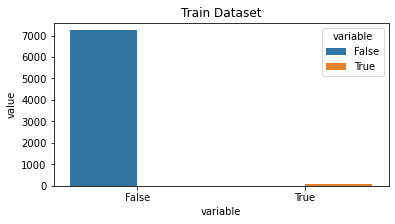

In [10]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k in torch.unique(dataset_obj.tensors[-1]).cpu().numpy()}
    for _, label_id in dataset_obj:
        label = label_id
        count_dict[np.bool(label.cpu().numpy())] += 1
    return count_dict
def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)
plt.figure(figsize=(6,3))
plot_from_dict(get_class_distribution(train_dataset), plot_title="Train Dataset")